# B(N)PO :: 3rd iteration of wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from alchemy.agent import Agent, BrainDescription
from alchemy.env import Env

import model

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load CONFIG :: TODO -> more implicit config

In [2]:
TOTAL_ENV = 20
GOAL_SIZE = 3
STATE_SIZE = 33 - GOAL_SIZE
ACTION_SIZE = 4
N_STEP = 10

N_HISTORY = 1#4#
N_ACTORS = 1
MAX_STEPS = 70

DEVICE = "cpu"

### 3. Load Environment

In [3]:
from tasks.uml_reacher_moving_mrocs import StaticReacherProxy, N_REWARDS, f_reward
from utils.task import Task

task = Task(StaticReacherProxy, 30.)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 4. Encoders

In [4]:
from utils.encoders import *
from utils.rnn import FasterGRUEncoder

def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)
    return StackedEncoder(
            GlobalNormalizer(STATE_SIZE, N_HISTORY),
            FasterGRUEncoder(STATE_SIZE, N_HISTORY, 2 * 48, 2))

def GoalEncoder():
    return GoalGlobalNorm(GOAL_SIZE)

encoder = Encoder()
encoder.share_memory()
goal_encoder = GoalEncoder()
goal_encoder.share_memory()

GoalGlobalNorm(
  (norm): Normalizer()
)

### 4. Actor + Critic models

In [5]:
def Actor(encoder, action_size):
    nes_layers = [encoder.out_size() + GOAL_SIZE, 400, 300, action_size]
    return lambda: model.ActorFactory(
        nes_layers, action_size=action_size, 
        f_mean_clip=lambda x: x, f_scale_clip=torch.tanh,
        device=DEVICE)

def Critic(encoder, action_size, n_rewards):
    return lambda: model.Critic(N_ACTORS, n_rewards, encoder.out_size(), action_size)

### 5. Debug out callback, post priting graph + meassuring time

In [6]:
from timebudget import timebudget
try:
    timebudget.set_quiet()
except:
    pass
import time
env_start = time.time()
env_counter = 0
def callback(bot, task, test_scores, learn_scores, seeds, total):
    global env_start, env_counter
    env_counter += 1
    if test_scores is None:
        return
    print("\n\t [", env_counter, "] < %.2f"%(time.time()-env_start), "sec > TEST ==> ", test_scores, "exploring score:", learn_scores.mean())
    timebudget.report("_clocked_step")

### 6. HER implementation ~ buffer specialization

In [7]:
from utils.her import HER, CreditAssignment

import random
class ReacherHER(HER):
    def update_goal(self, rewards, goals, states, states_1, n_goals, n_states, actions, her_step_inds, n_steps):
        MAX_HER_STEP = 1
        gid = 0
        delta = 0
        h_rewards = rewards.clone()
        h_goals = goals.clone()
        h_n_goals = n_goals.clone()
        for i, (g, s, n_g, n, u, step) in enumerate(zip(goals, states, n_goals, n_states, her_step_inds, n_steps)):
            her_active = bool(sum(her_step_inds[(i-MAX_HER_STEP) if MAX_HER_STEP < i else 0:i]))

            if not her_active and u: # we will set-up new goal
                gid = random.randint(0, len(goals[:-self.n_step-MAX_HER_STEP])-1)
                delta = 0

            if her_active or u:
                if gid+delta+self.n_step<len(goals) and i<len(goals)-self.n_step:# previous state was assigned HER
                    g, n_g = goals[gid+delta], goals[gid+delta+step]
                delta += 1

            h_rewards[i] = torch.tensor(f_reward(s, n, g, None, True, None, None))
            h_goals[i] = g.clone()
            h_n_goals[i] = n_g.clone()
        return ( h_rewards, h_goals, states, h_n_goals, n_states )

def ReacherCreditAssignment(cind, gae, n_step, floating_step, gamma, gae_tau, her_delay):
    print("HER IS TURNED OFF!!")
    return CreditAssignment(cind=cind, gae=gae, n_step=n_step, floating_step=floating_step, gamma=gamma, gae_tau=gae_tau)

### 7. Setup agent ( memory + credit assignment + environment and algorithm ~ actor-critic )

In [8]:
from utils.memory import Memory
from utils.memlocal import MemoryBoost

def new_agent(
    her, brains, 
    goal_encoder, encoder, freeze_delta, freeze_count, 
    action_size, n_rewards, n_step, max_steps,
    detach_actors, detach_critics, stable_probs,
    good_reach=1, model_path="checkpoints", save=False, load=False,
    eval_delay=20
    ):
    
    credit_assign = [ ReacherHER(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=h) if h else ReacherCreditAssignment(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=None) for i, h in enumerate(her) ]

    # g, s, f, a, p, r, n_g, n_s, n_f, c, d
    memory = Memory(20 * max_steps * 200, recalc_delay=5, chunks=[
        GOAL_SIZE, STATE_SIZE, encoder.features_n(), 3*action_size, action_size, 
        n_rewards, GOAL_SIZE, STATE_SIZE, encoder.features_n(), n_rewards, 1], 
                    ep_draw=10, device=DEVICE)

    experience = lambda descs, brain: MemoryBoost(descs, memory, credit_assign, brain, n_step, good_reach)

    agent = Agent(
        DEVICE,
        brains, experience,
        Actor=Actor(encoder, action_size), Critic=Critic(encoder, action_size, n_rewards), 
        goal_encoder=goal_encoder, encoder=encoder, 
        n_agents=1, detach_actors=detach_actors, detach_critics=detach_critics, stable_probs=stable_probs,
        resample_delay=10, min_step=n_step*2,
        state_size=STATE_SIZE, action_size=action_size,
        freeze_delta=freeze_delta, freeze_count=freeze_count,
        lr_critic=5e-5, clip_norm=1.,
        model_path=model_path, save=save, load=load, delay=10
    )

    # defined above
    env = Env(agent, 
            total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
            n_step=n_step, send_delta=max_steps,
            eval_limit=10, eval_ratio=.5, max_n_episode=max_steps, eval_delay=eval_delay,
            mcts_random_cap=100000, mcts_rounds=1, mcts_random_ratio=10, limit=2000)
    
    return agent, env

## 8. in depth setup of ALGORITHMs used ( bpo ~> ppo / ddpg / natural )

In [9]:
BS = 2048

bpo_brain = [
    
        BrainDescription( # master :: PPO
            memory_size=20 * MAX_STEPS * 10, batch_size=1024, 
            
            optim_pool_size=(MAX_STEPS * 40 * 6 * 6 * 1) // 3,
            optim_epochs=1, optim_batch_size=1*BS, recalc_delay=2,
            
            lr_actor=1e-4, learning_delay=1*N_STEP, learning_repeat=6,

            sync_delta_a=1, sync_delta_c=1, tau_actor=1e-1, tau_critic=0,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=False),
    
        BrainDescription( # master :: PPO
            memory_size=20 * MAX_STEPS * 6, batch_size=BS, 
            
            optim_pool_size=(MAX_STEPS * 80 * 20) // 3,
            optim_epochs=1, optim_batch_size=1*BS, recalc_delay=2,
            
            lr_actor=1e-4, learning_delay=3*MAX_STEPS, learning_repeat=20, # train here more will do also job!
            sync_delta_a=1, sync_delta_c=1, tau_actor=1, tau_critic=1,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=False),

]
print("\nB(N)PO: \n", [b for b in bpo_brain])


B(N)PO: 
 [[14000, '<- memory_size;', 1024, '<- batch_size;', 1, '<- optim_epochs;', 2048, '<- optim_batch_size;', 33600, '<- optim_pool_size;', 2, '<- recalc_delay;', 1, '<- sync_delta_a;', 1, '<- sync_delta_c;', 10, '<- learning_delay;', 6, '<- learning_repeat;', 0.0001, '<- lr_actor;', 0.1, '<- tau_actor;', 0, '<- tau_critic;', 0.2, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;'], [8400, '<- memory_size;', 2048, '<- batch_size;', 1, '<- optim_epochs;', 2048, '<- optim_batch_size;', 37333, '<- optim_pool_size;', 2, '<- recalc_delay;', 1, '<- sync_delta_a;', 1, '<- sync_delta_c;', 210, '<- learning_delay;', 20, '<- learning_repeat;', 0.0001, '<- lr_actor;', 1, '<- tau_actor;', 1, '<- tau_critic;', 0.2, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;']]


## 9. LEARN!

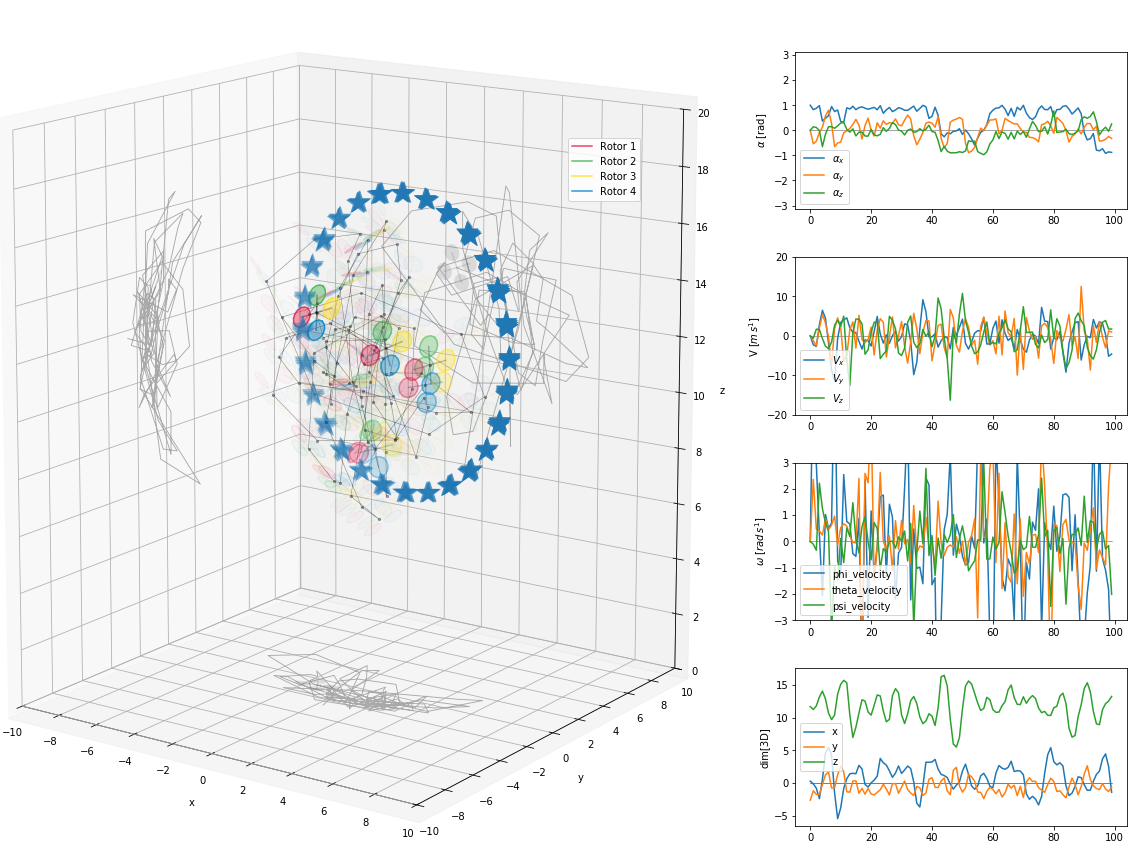

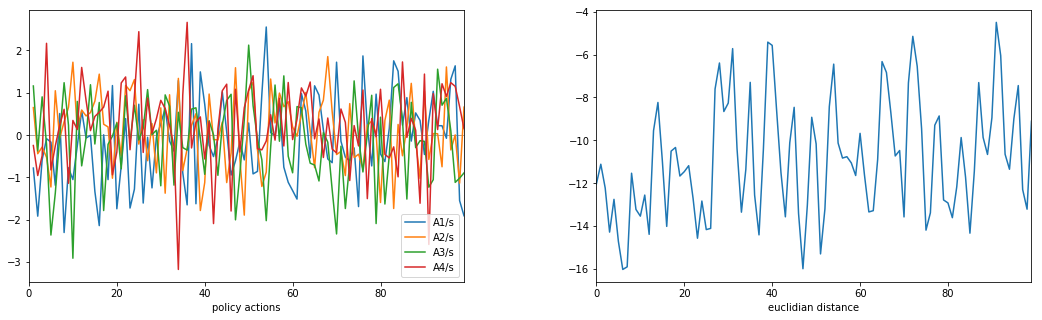

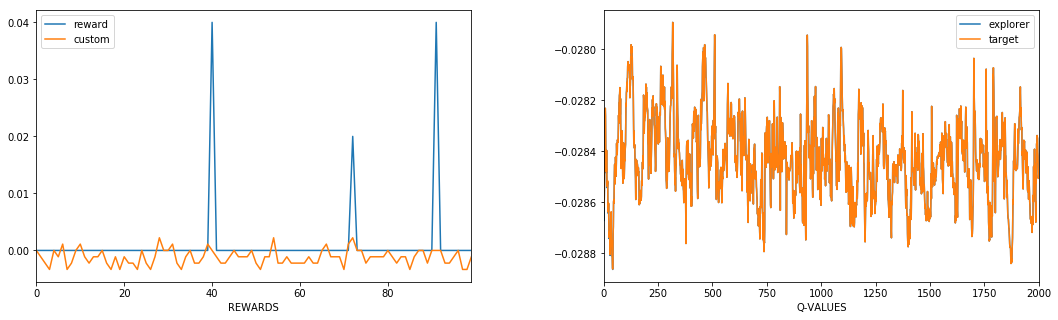

[   19>  1329:: 0] steps =   69, max_step =  70/ 70, reward=-0.041278 <action=tensor([ 1.0177,  2.5537, -0.8369, -0.2387])>                                    
	 [ 19 ] < 976.22 sec > TEST ==>  [[tensor(0.8935)], [tensor(1.0015)]] exploring score: tensor(-0.0416)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   652.68ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   652.61ms/cyc @     0.6execs/cyc
                    learn: 100.0%   652.59ms/cyc @     0.6execs/cyc
        FullMemory-sample:  90.2%   589.02ms/cyc @     0.2execs/cyc
            _push_to_fast:  79.1%   516.33ms/cyc @    54.0execs/cyc
                 __call__:  29.4%   191.73ms/cyc @    54.3execs/cyc
                   _learn:  13.2%    85.83ms/cyc @     0.6execs/cyc
        FastMemory-sample:   9.7%    63.52ms/cyc @     0.4execs/cyc
                 backprop:   6.5%    42.40ms/cyc @     1.3execs/cyc
             recalc_feats:   0.8%     5.22ms/cyc @     9.4execs/cyc
           

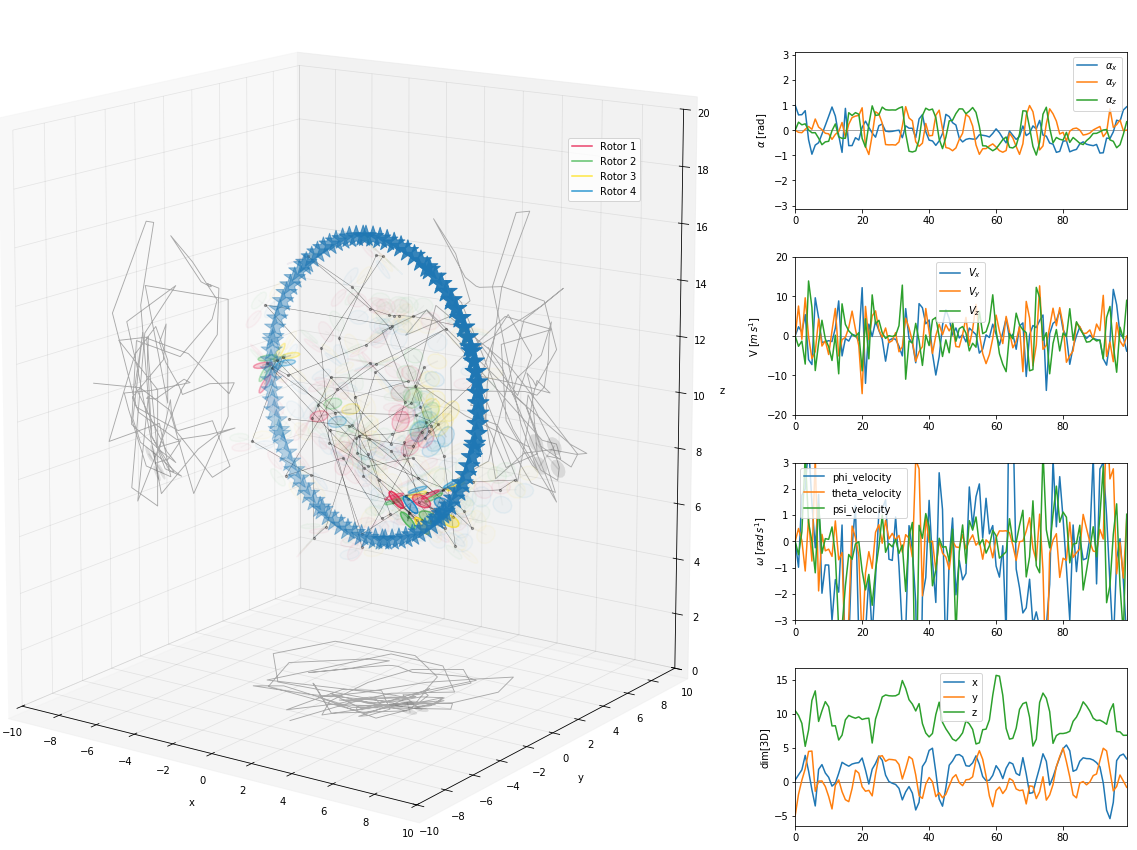

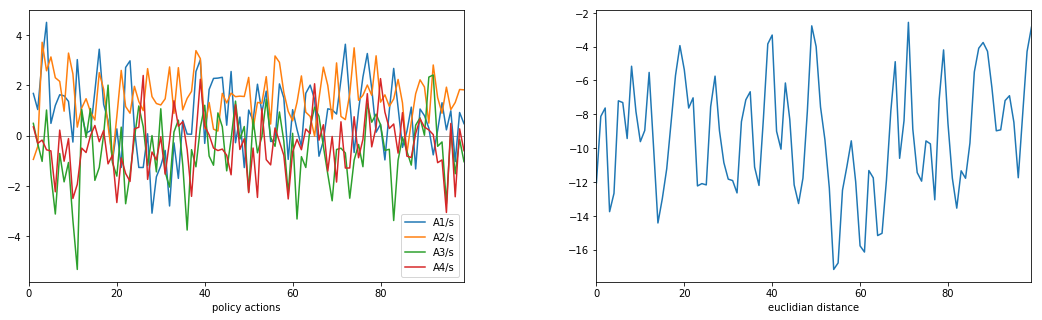

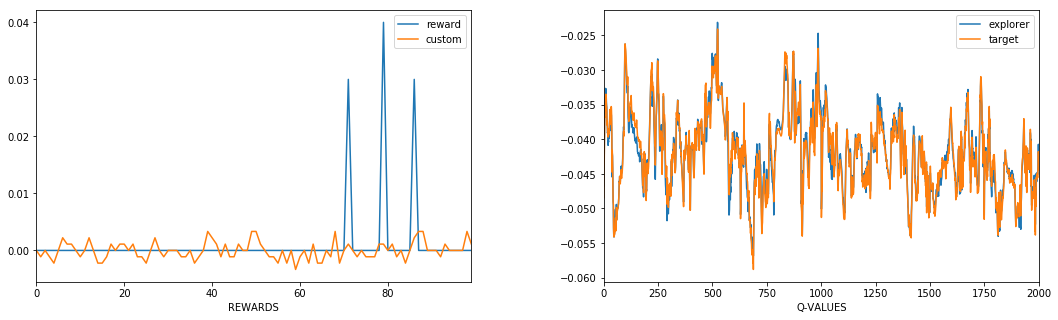

[   39>  2729:: 0] steps =   69, max_step =  70/ 70, reward=0.002167 <action=tensor([-1.3932,  0.9571,  0.3023, -0.4189])>                                     
	 [ 39 ] < 2044.39 sec > TEST ==>  [[tensor(1.6840)], [tensor(1.7100)]] exploring score: tensor(0.0027)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   680.04ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   679.97ms/cyc @     0.7execs/cyc
                    learn: 100.0%   679.94ms/cyc @     0.7execs/cyc
        FullMemory-sample:  90.2%   613.59ms/cyc @     0.2execs/cyc
            _push_to_fast:  79.2%   538.79ms/cyc @    56.2execs/cyc
                 __call__:  29.3%   199.15ms/cyc @    56.4execs/cyc
                   _learn:  13.0%    88.22ms/cyc @     0.7execs/cyc
        FastMemory-sample:   9.8%    66.30ms/cyc @     0.4execs/cyc
                 backprop:   6.5%    44.34ms/cyc @     1.3execs/cyc
                    _push:   0.8%     5.55ms/cyc @     0.3execs/cyc
           

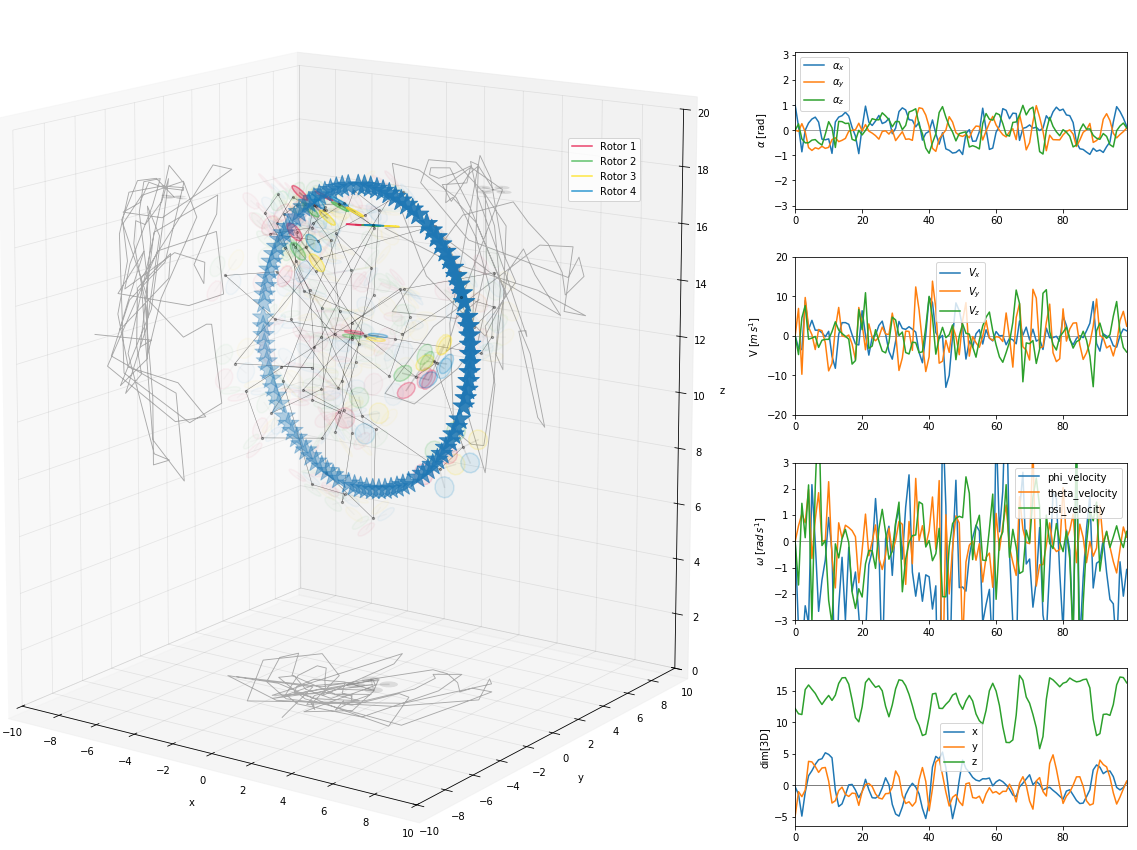

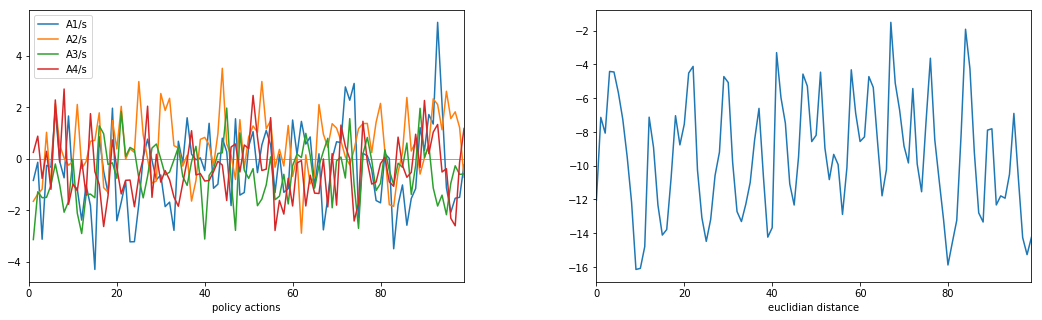

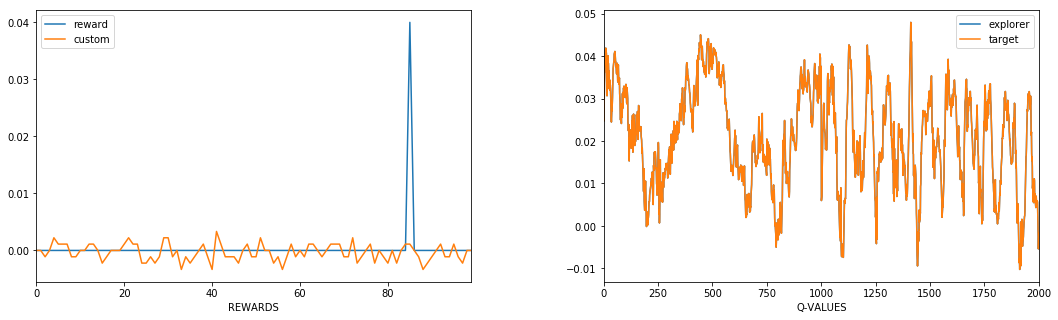

[   59>  4129:: 0] steps =   69, max_step =  70/ 70, reward=0.030889 <action=tensor([-0.6798,  1.8826,  1.5757, -0.7399])>                                     
	 [ 59 ] < 3028.39 sec > TEST ==>  [[tensor(2.0430)], [tensor(2.3070)]] exploring score: tensor(0.0316)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   667.88ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   667.81ms/cyc @     0.7execs/cyc
                    learn: 100.0%   667.79ms/cyc @     0.7execs/cyc
        FullMemory-sample:  90.0%   600.96ms/cyc @     0.2execs/cyc
            _push_to_fast:  79.0%   527.83ms/cyc @    55.4execs/cyc
                 __call__:  29.3%   195.48ms/cyc @    55.7execs/cyc
                   _learn:  13.2%    88.19ms/cyc @     0.7execs/cyc
        FastMemory-sample:  10.0%    66.78ms/cyc @     0.4execs/cyc
                 backprop:   6.7%    44.56ms/cyc @     1.3execs/cyc
                    _push:   1.1%     7.12ms/cyc @     0.3execs/cyc
           

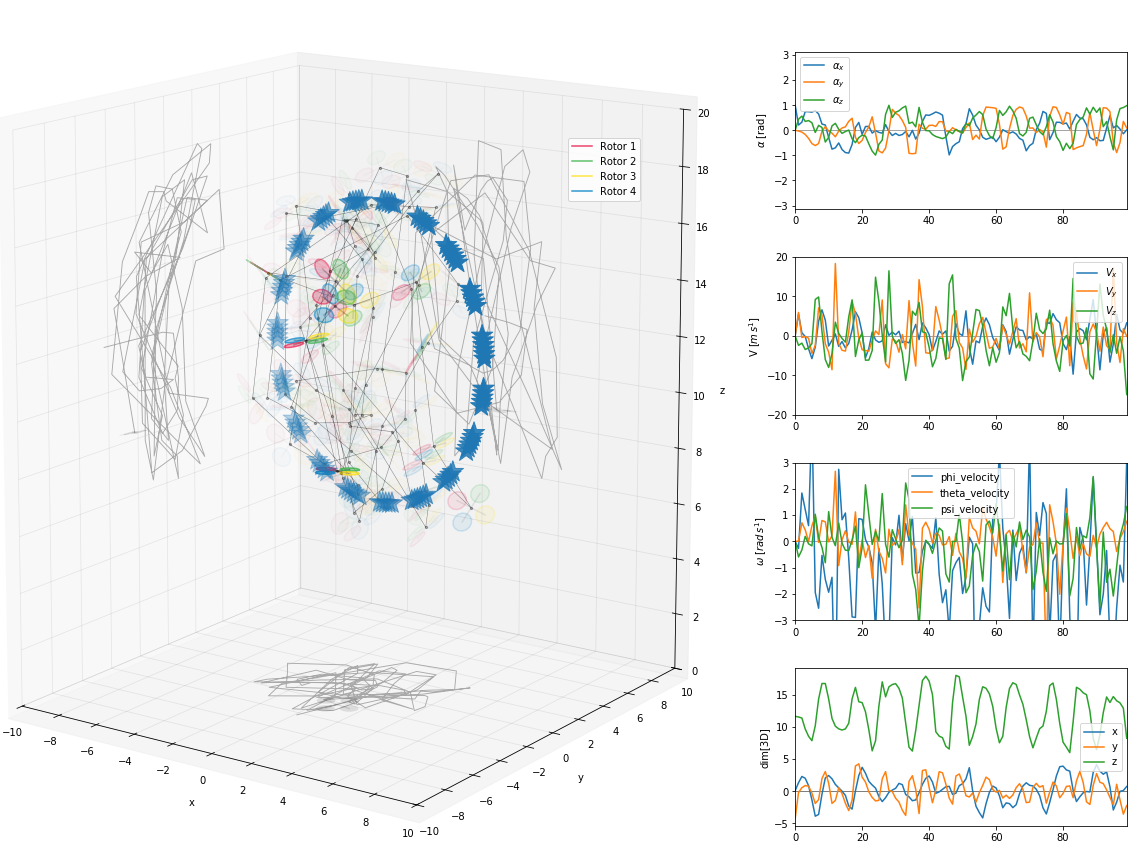

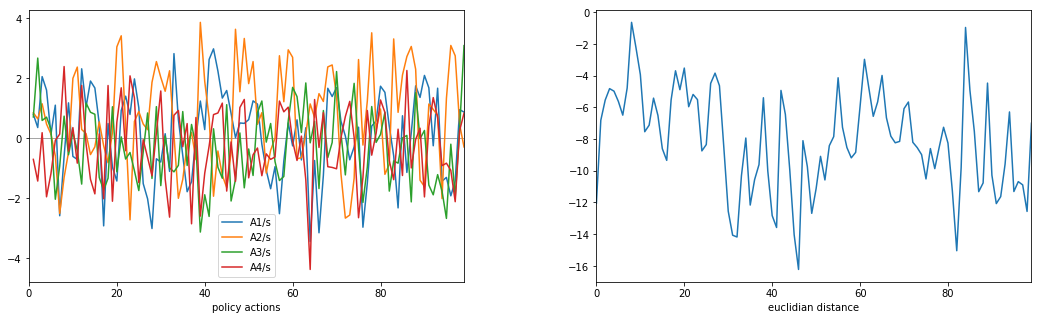

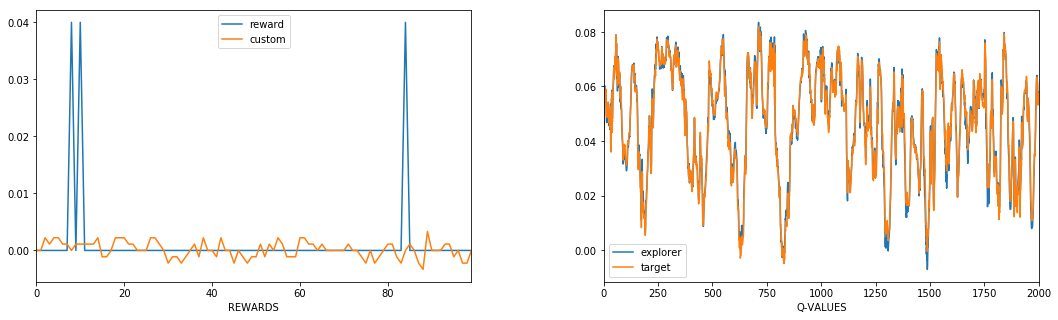

[   79>  5529:: 0] steps =   69, max_step =  70/ 70, reward=0.069278 <action=tensor([ 0.2661,  1.2974, -0.4756, -0.2095])>                                    
	 [ 79 ] < 4089.37 sec > TEST ==>  [[tensor(4.6330)], [tensor(5.0280)]] exploring score: tensor(0.0703)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   675.08ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   675.01ms/cyc @     0.7execs/cyc
                    learn: 100.0%   674.98ms/cyc @     0.7execs/cyc
        FullMemory-sample:  90.0%   607.57ms/cyc @     0.2execs/cyc
            _push_to_fast:  79.1%   533.78ms/cyc @    56.2execs/cyc
                 __call__:  29.3%   197.83ms/cyc @    56.5execs/cyc
                   _learn:  13.2%    89.07ms/cyc @     0.7execs/cyc
        FastMemory-sample:  10.0%    67.37ms/cyc @     0.5execs/cyc
                 backprop:   6.7%    45.13ms/cyc @     1.4execs/cyc
                    _push:   1.3%     8.63ms/cyc @     0.3execs/cyc
            

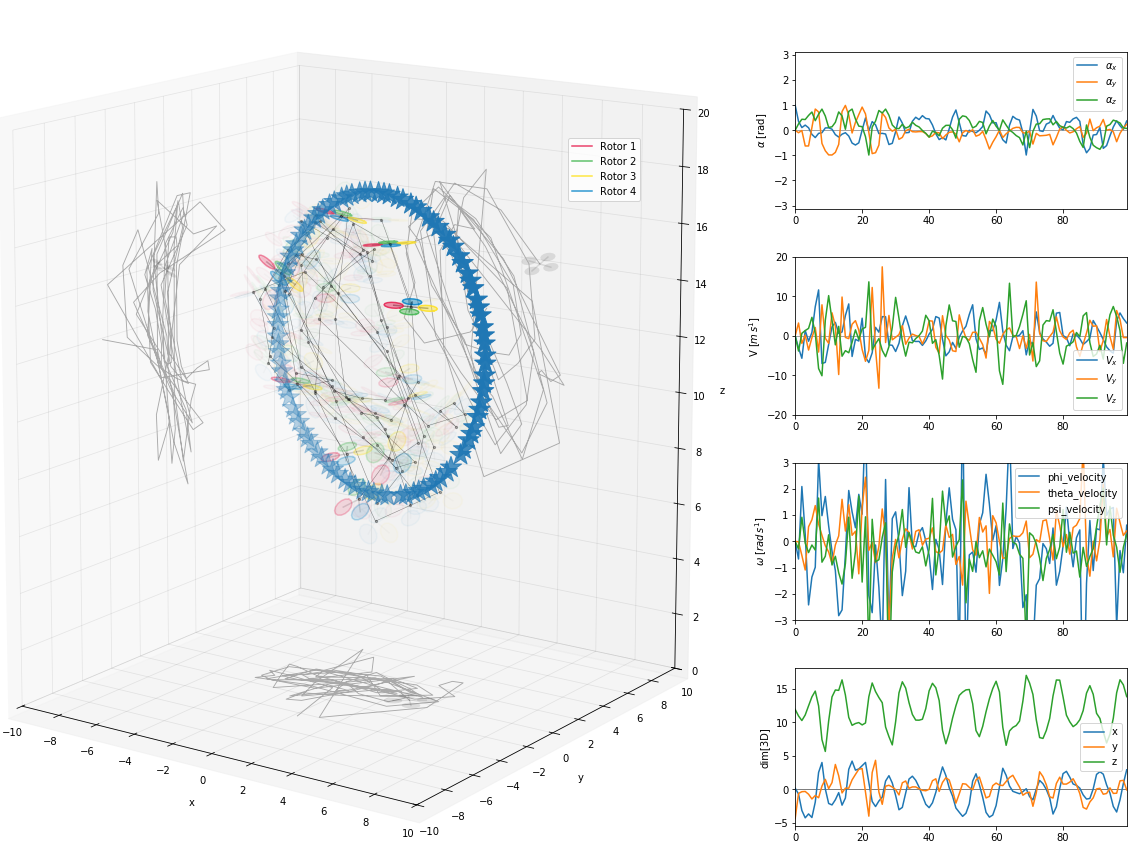

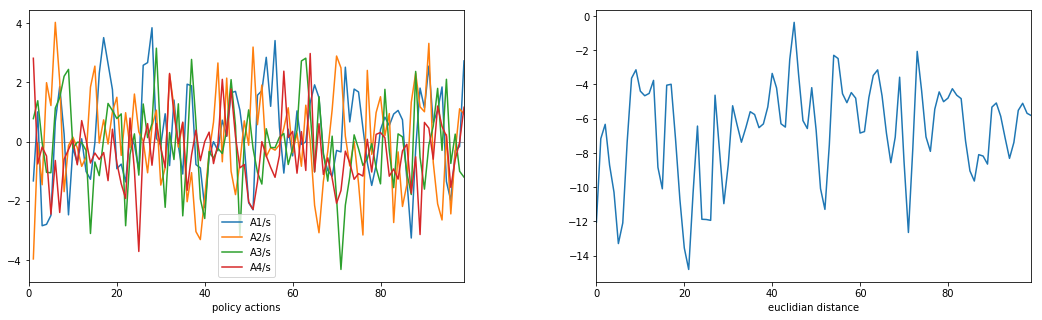

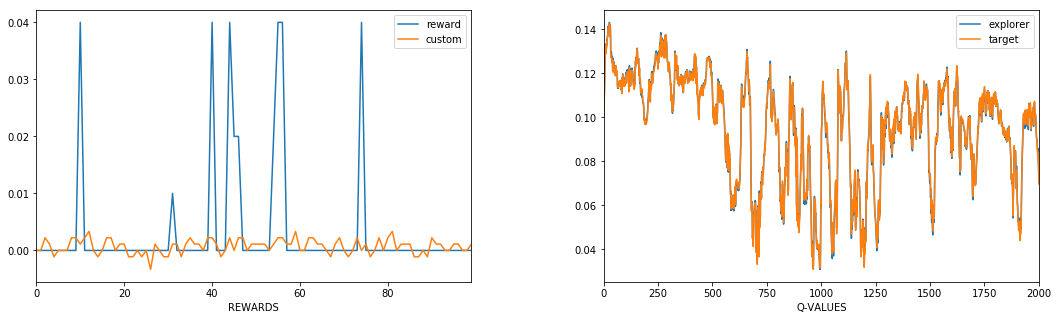

[   99>  6929:: 0] steps =   69, max_step =  70/ 70, reward=0.100389 <action=tensor([-3.0088, -0.6160,  0.4097, -0.9022])>                                     
	 [ 99 ] < 5122.06 sec > TEST ==>  [[tensor(7.9510)], [tensor(6.3190)]] exploring score: tensor(0.1023)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   674.59ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   674.52ms/cyc @     0.7execs/cyc
                    learn: 100.0%   674.49ms/cyc @     0.7execs/cyc
        FullMemory-sample:  90.0%   606.92ms/cyc @     0.2execs/cyc
            _push_to_fast:  79.0%   533.14ms/cyc @    56.4execs/cyc
                 __call__:  29.3%   197.85ms/cyc @    56.6execs/cyc
                   _learn:  13.2%    89.25ms/cyc @     0.7execs/cyc
        FastMemory-sample:  10.0%    67.52ms/cyc @     0.5execs/cyc
                 backprop:   6.7%    45.35ms/cyc @     1.4execs/cyc
                    _push:   1.5%    10.10ms/cyc @     0.3execs/cyc
           

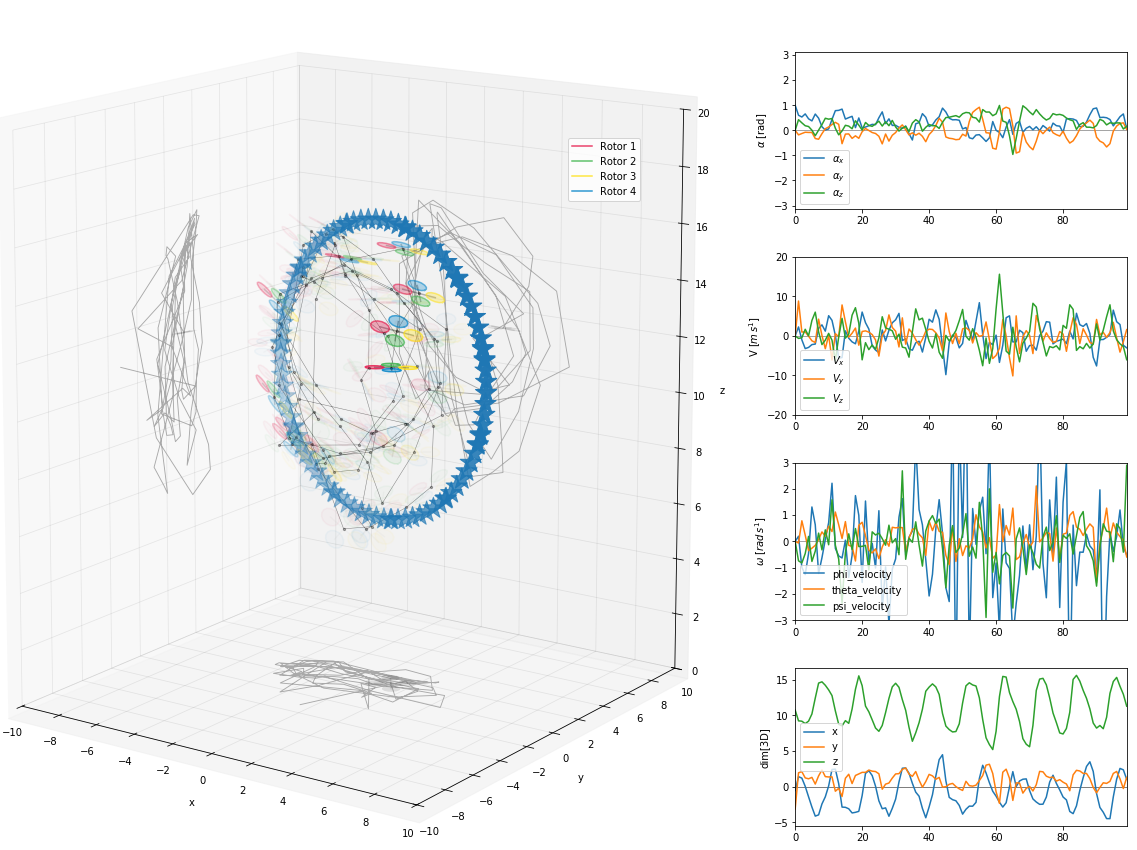

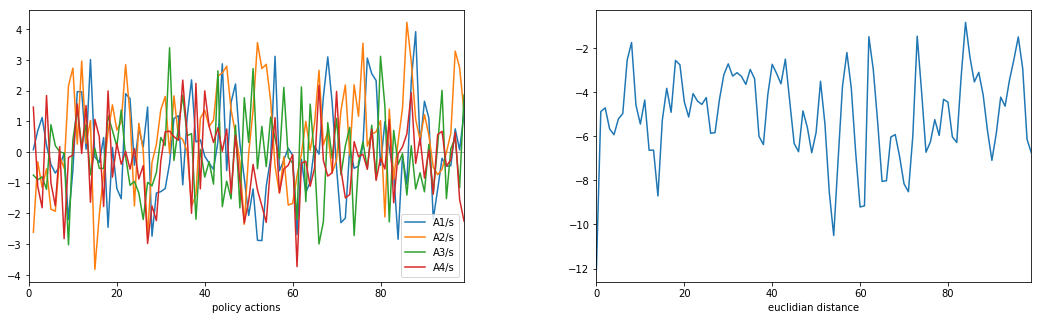

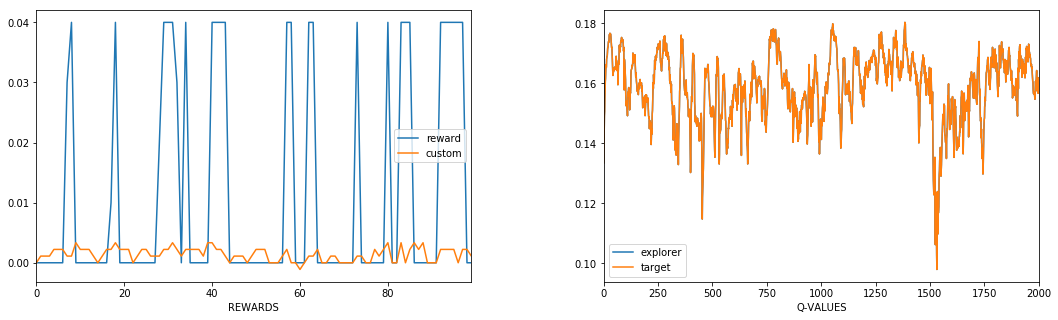

[  119>  8329:: 0] steps =   69, max_step =  70/ 70, reward=0.107333 <action=tensor([-1.2421, -0.8666,  0.9850,  1.6524])>                                     
	 [ 119 ] < 6151.03 sec > TEST ==>  [[tensor(21.2425)], [tensor(20.8505)]] exploring score: tensor(0.1095)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   673.50ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   673.43ms/cyc @     0.7execs/cyc
                    learn: 100.0%   673.40ms/cyc @     0.7execs/cyc
        FullMemory-sample:  90.0%   606.08ms/cyc @     0.2execs/cyc
            _push_to_fast:  79.1%   532.42ms/cyc @    56.3execs/cyc
                 __call__:  29.3%   197.61ms/cyc @    56.6execs/cyc
                   _learn:  13.2%    89.03ms/cyc @     0.7execs/cyc
        FastMemory-sample:  10.0%    67.28ms/cyc @     0.5execs/cyc
                 backprop:   6.7%    45.43ms/cyc @     1.4execs/cyc
                    _push:   1.7%    11.59ms/cyc @     0.3execs/cyc
        

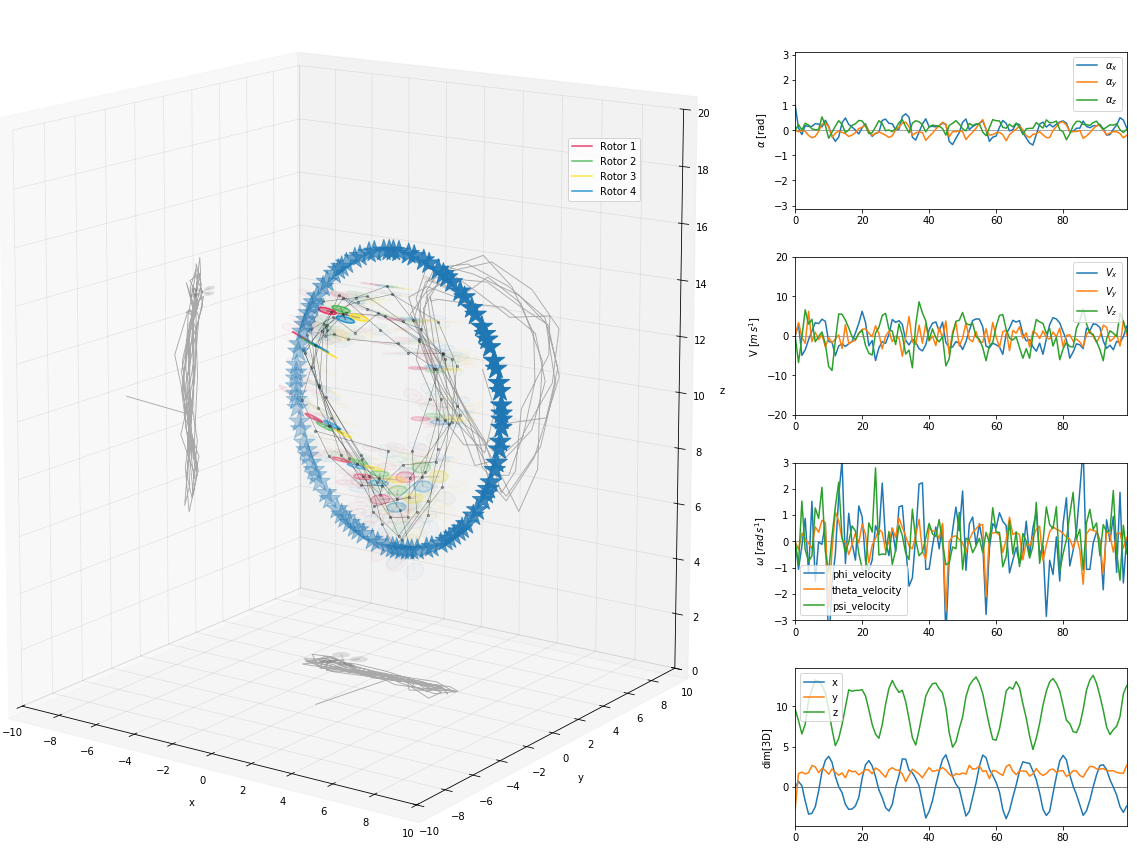

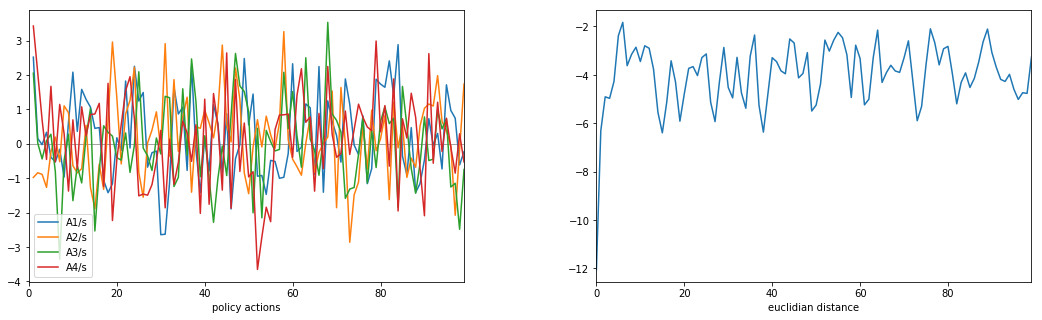

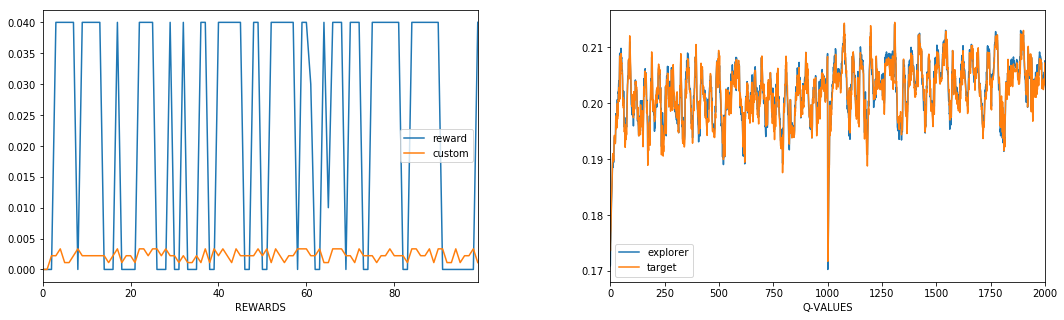

[  139>  9729:: 0] steps =   69, max_step =  70/ 70, reward=0.127000 <action=tensor([ 0.0964, -0.7311, -0.5813, -0.5919])>                                     
	 [ 139 ] < 7180.87 sec > TEST ==>  [[tensor(27.3270)], [tensor(27.6915)]] exploring score: tensor(0.1295)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   672.29ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   672.22ms/cyc @     0.7execs/cyc
                    learn: 100.0%   672.19ms/cyc @     0.7execs/cyc
        FullMemory-sample:  89.9%   604.61ms/cyc @     0.2execs/cyc
            _push_to_fast:  79.0%   531.19ms/cyc @    56.3execs/cyc
                 __call__:  29.3%   197.08ms/cyc @    56.6execs/cyc
                   _learn:  13.3%    89.16ms/cyc @     0.7execs/cyc
        FastMemory-sample:  10.0%    67.54ms/cyc @     0.5execs/cyc
                 backprop:   6.8%    45.53ms/cyc @     1.4execs/cyc
                    _push:   1.9%    13.05ms/cyc @     0.3execs/cyc
        

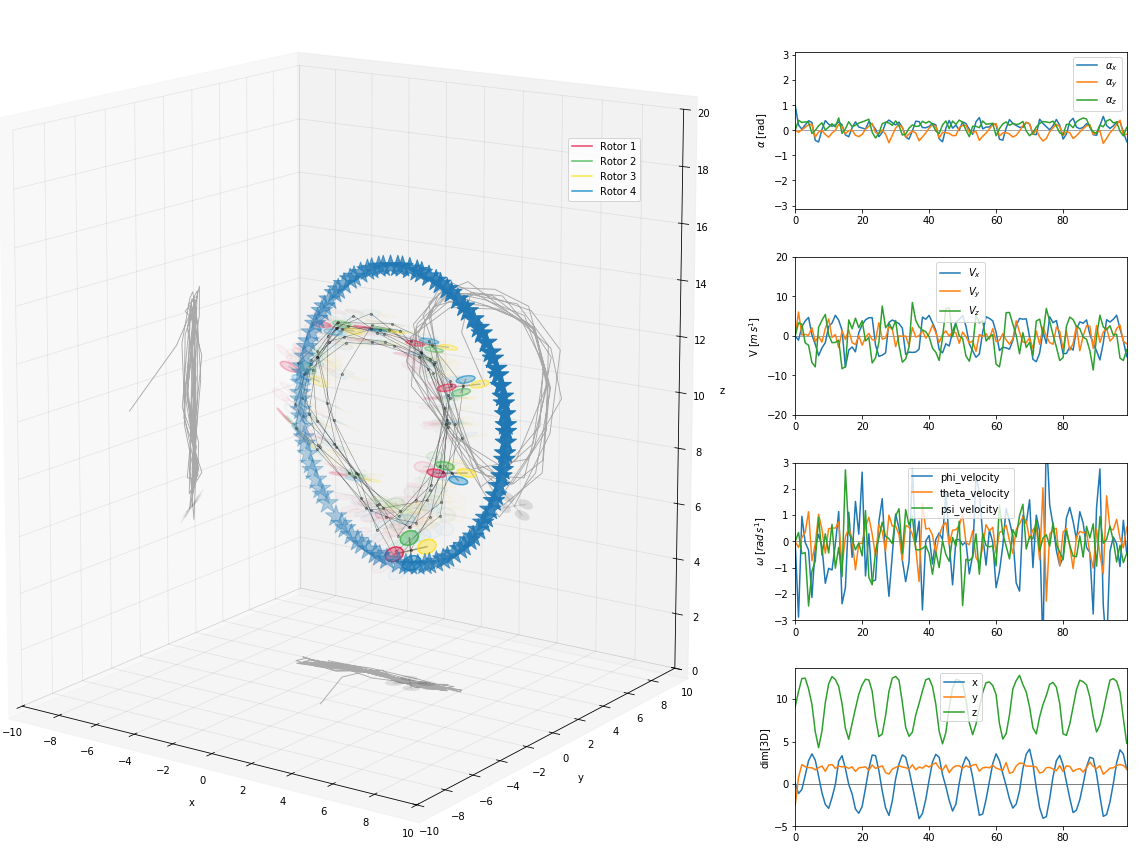

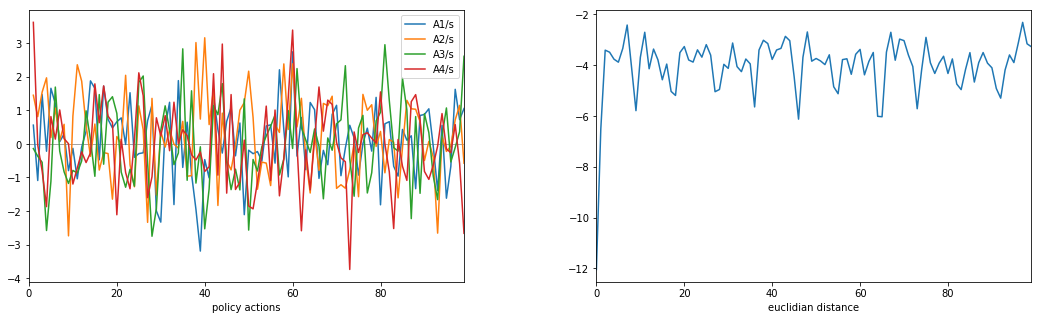

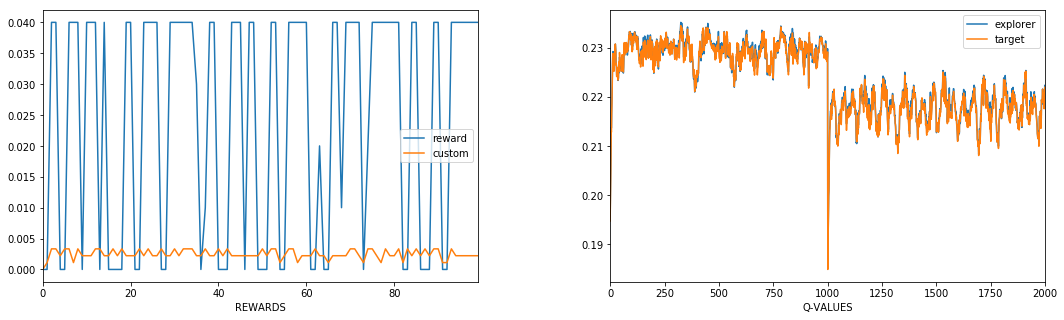

[  159> 11129:: 0] steps =   69, max_step =  70/ 70, reward=0.129389 <action=tensor([ 0.9885, -0.6628, -0.9580, -1.2896])>                                    
	 [ 159 ] < 8266.59 sec > TEST ==>  [[tensor(30.3270), tensor(28.8325)], [tensor(28.3000), tensor(28.1625)]] exploring score: tensor(0.1319)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   672.90ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   672.83ms/cyc @     0.7execs/cyc
                    learn: 100.0%   672.80ms/cyc @     0.7execs/cyc
        FullMemory-sample:  89.9%   605.01ms/cyc @     0.2execs/cyc
            _push_to_fast:  79.0%   531.57ms/cyc @    56.4execs/cyc
                 __call__:  29.3%   197.25ms/cyc @    56.7execs/cyc
                   _learn:  13.3%    89.37ms/cyc @     0.7execs/cyc
        FastMemory-sample:  10.1%    67.75ms/cyc @     0.5execs/cyc
                 backprop:   6.8%    45.68ms/cyc @     1.4execs/cyc
                    _push:   2.2%    14.55m

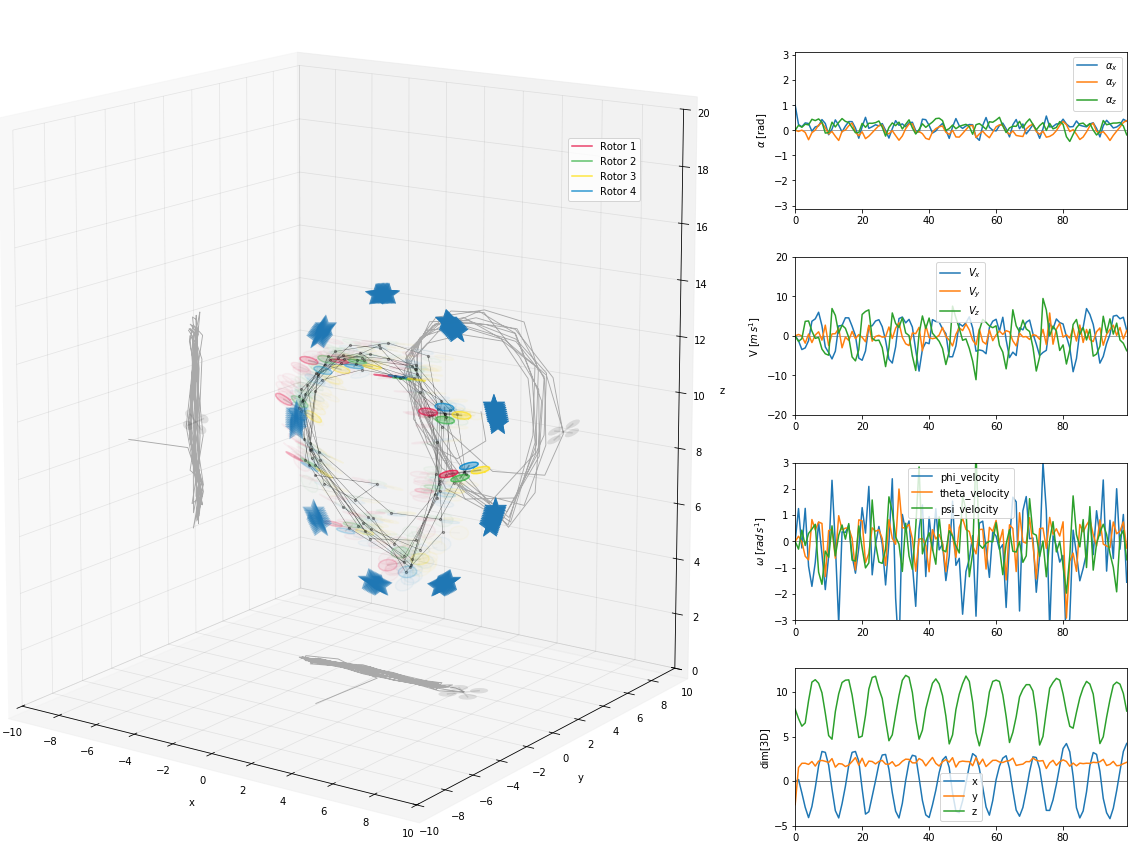

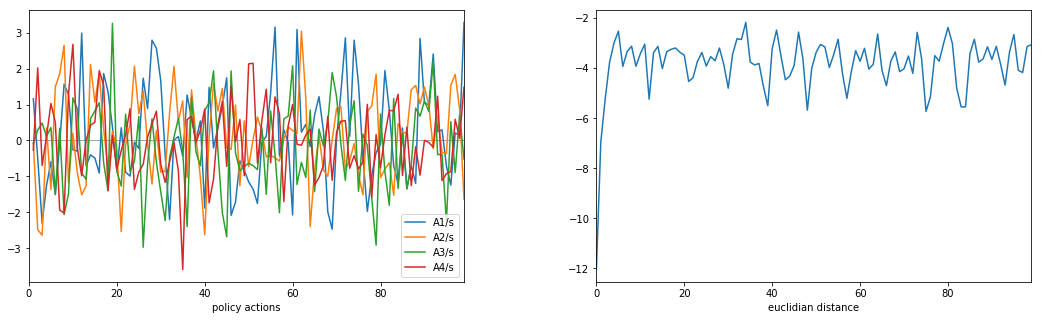

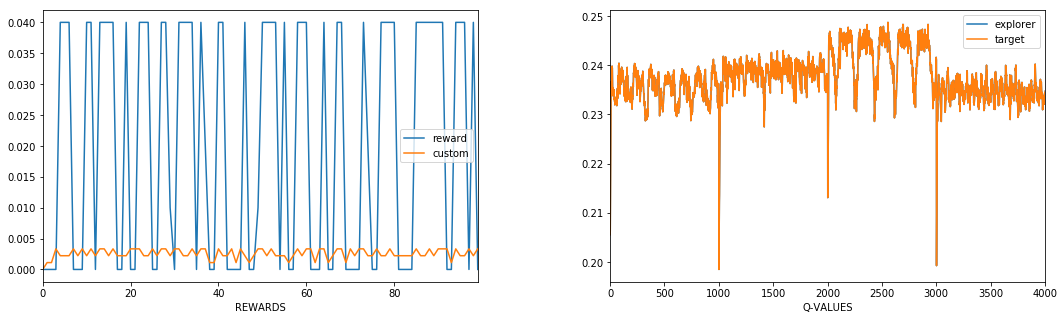

[  179> 12529:: 0] steps =   69, max_step =  70/ 70, reward=0.138556 <action=tensor([-0.2827,  0.3075, -1.0132,  0.6606])>                                    
 environment solved!  32.65627427007537 [array([32.05049928, 33.26204926])]
[[tensor(32.5640), tensor(31.4785), tensor(31.8330), tensor(32.4495), tensor(32.6450), tensor(31.8680), tensor(32.2890), tensor(32.5230), tensor(31.7345), tensor(31.1205)], [tensor(33.5410), tensor(34.5320), tensor(32.8145), tensor(33.0310), tensor(32.7955), tensor(32.5830), tensor(34.0490), tensor(32.8910), tensor(33.8280), tensor(32.5555)]]

	 [ 179 ] < 9670.08 sec > TEST ==>  [[tensor(32.5640), tensor(31.4785), tensor(31.8330), tensor(32.4495), tensor(32.6450), tensor(31.8680), tensor(32.2890), tensor(32.5230), tensor(31.7345), tensor(31.1205)], [tensor(33.5410), tensor(34.5320), tensor(32.8145), tensor(33.0310), tensor(32.7955), tensor(32.5830), tensor(34.0490), tensor(32.8910), tensor(33.8280), tensor(32.5555)]] exploring score: tensor(0.1411)
timebu

In [10]:
agent, env = new_agent(
    [2, 2], bpo_brain, 
    goal_encoder, encoder, freeze_delta=3, freeze_count=3, 
    action_size=4, n_rewards=N_REWARDS, n_step=N_STEP, max_steps=MAX_STEPS,
    detach_actors=True, detach_critics=False, stable_probs=False,
    good_reach=1, model_path="checkpoints", save=True, load=False
    )
scores = env.start(task, callback)

In [11]:
losses = agent.brain.losses
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex = losses
losses = np.vstack(losses_ex)[::len(losses_ex)//200]

### 10. Plot training reward + loss

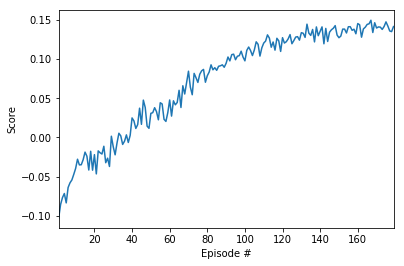

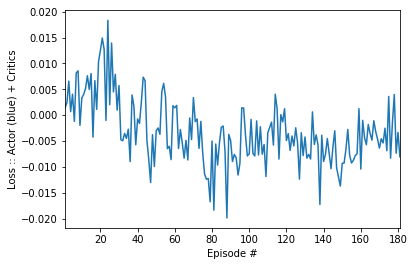

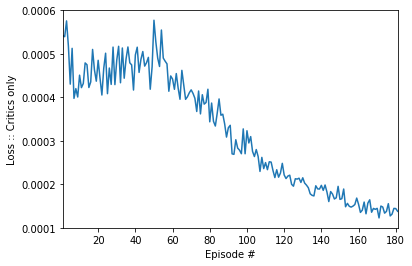

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 0])
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 1:])
plt.ylabel('Loss :: Critics only')
plt.xlabel('Episode #')
plt.show() 

### 11. Reload trained agent

In [13]:
agent.sync_target(0, [])
agent.sync_explorer(0, [])

### 12. Test visuals - TARGET


 environment solved!  32.658174270032916 [array([32.04029928, 33.27604926])]
[[tensor(32.4230), tensor(33.4650), tensor(31.9120), tensor(32.4005), tensor(31.9405), tensor(31.8875), tensor(30.3760), tensor(32.1015), tensor(32.1475), tensor(31.7495)], [tensor(32.1890), tensor(33.8725), tensor(33.1745), tensor(33.4545), tensor(33.4385), tensor(32.8100), tensor(34.2495), tensor(34.3540), tensor(32.4130), tensor(32.8050)]]

 environment solved!  32.70994926887563 [array([32.01684928, 33.40304925])]
[[tensor(32.2260), tensor(31.1405), tensor(31.7560), tensor(32.4685), tensor(32.5060), tensor(32.2055), tensor(32.6540), tensor(32.2255), tensor(30.5345), tensor(32.4520)], [tensor(33.8740), tensor(32.5870), tensor(33.7310), tensor(33.6735), tensor(33.2150), tensor(33.5230), tensor(32.4815), tensor(33.6940), tensor(33.4465), tensor(33.8050)]]

 environment solved!  32.63689927050843 [array([32.35309928, 32.92069926])]
[[tensor(32.2990), tensor(32.6585), tensor(31.6790), tensor(32.6340), tensor(3

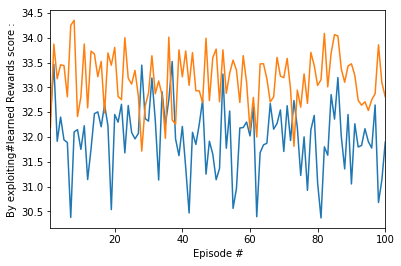

In [14]:
rewards = [[], []]
while len(rewards[0]) < 100:
    success, scores = env.evaluate(task)
    [ rewards[i].extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards), np.mean(rewards, 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for r in rewards:
    plt.plot(np.arange(1, len(r)+1), r)
plt.ylabel('By exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 13. Test visuals - EXPLORER


 environment solved!  31.12754930424503 [array([31.1670993 , 31.08799931])]
[[tensor(31.4695), tensor(30.8725), tensor(29.8015), tensor(32.3220), tensor(32.0315), tensor(32.0835), tensor(31.7235), tensor(31.1610), tensor(30.1830), tensor(30.0230)], [tensor(31.7130), tensor(32.0785), tensor(30.0180), tensor(31.1265), tensor(32.2960), tensor(31.9435), tensor(30.9680), tensor(30.4570), tensor(29.6925), tensor(30.5870)]]

 environment solved!  31.144024303876797 [array([31.2047993 , 31.08324931])]
[[tensor(32.1775), tensor(31.9235), tensor(32.1540), tensor(30.5770), tensor(31.0585), tensor(31.9995), tensor(30.4025), tensor(31.5710), tensor(30.8260), tensor(29.3585)], [tensor(31.3475), tensor(30.5790), tensor(31.5390), tensor(31.1595), tensor(31.7710), tensor(31.6655), tensor(31.7360), tensor(30.7410), tensor(29.7910), tensor(30.5030)]]

 environment solved!  31.162249303469423 [array([30.99749931, 31.3269993 ])]
[[tensor(31.5100), tensor(31.1580), tensor(28.8580), tensor(32.0325), tensor(

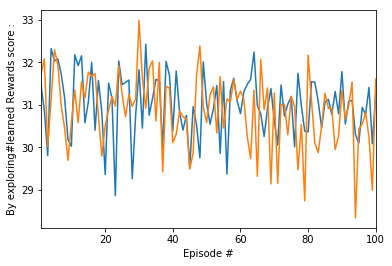

In [15]:
# for evaluation we will set target network to be explorer
agent.brain.ac_target = agent.brain.ac_explorer

rewards = [[], []]
while len(rewards[0]) < 100:
    success, scores = env.evaluate(task)
    [ rewards[i].extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards), np.mean(rewards, 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for r in rewards:
    plt.plot(np.arange(1, len(r)+1), r)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()